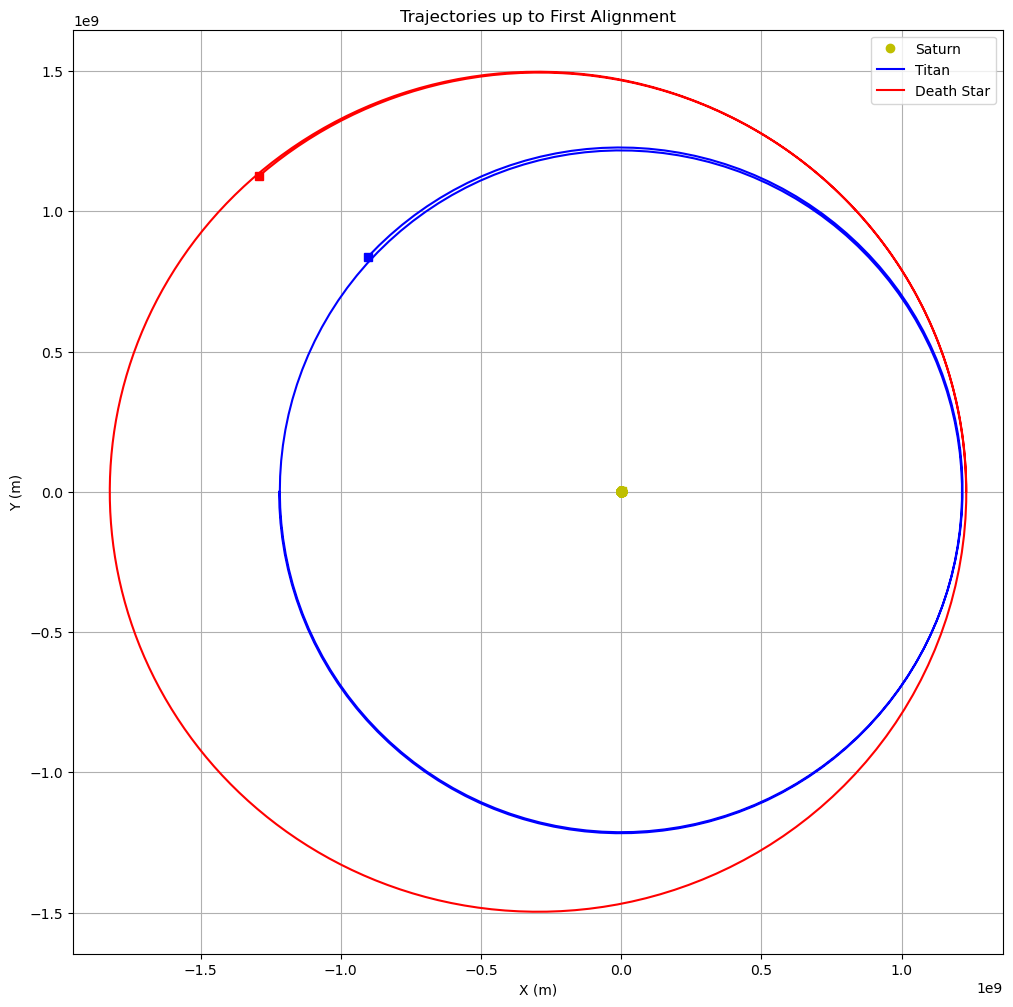

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# Initial state setup

# Initial positions [x, y] in meters
r_s_initial = np.array([0.0, 0.0])  # Saturn at the origin
r_t_initial = np.array([-1.22e9, 0.0])  # Titan's average distance from Saturn is approximately 1.22 million km
r_ds_initial = np.array([1.22e9 + 1e7, 0.0])  # Death Star starts 10 million km further out than Titan

# Initial velocities [vx, vy] in meters per second (assuming circular orbits and ignoring the gravitational influence of other bodies for simplicity)
v_s_initial = np.array([0.0, 0.0])  # Saturn is stationary
v_t_initial = np.array([0.0, -5.57e3])  # Titan's average orbital speed is approximately 5.57 km/s
v_ds_initial = np.array([0.0, 5.57e3 + 500.0])  # Assuming Death Star's orbital speed is slightly higher than Titan's for simplicity

# Combining the initial state
initial_state = np.hstack([r_s_initial, v_s_initial, r_t_initial, v_t_initial, r_ds_initial, v_ds_initial])

initial_state



# Constants
G = 6.67430e-11  # gravitational constant
M_s = 568.32e24  # mass of Saturn
M_t = 1.345e23   # mass of Titan
M_ds = 2.24e23   # mass of Death Star

# Differential equations (derivatives)
def derivatives(t, state):
    r_s, v_s, r_t, v_t, r_ds, v_ds = state.reshape(6, -1)
    d_st = np.linalg.norm(r_s - r_t)
    d_sds = np.linalg.norm(r_s - r_ds)
    d_tds = np.linalg.norm(r_t - r_ds)
    
    f_st = G * M_s * M_t / d_st**3
    f_sds = G * M_s * M_ds / d_sds**3
    f_tds = G * M_t * M_ds / d_tds**3
    
    a_s = f_st * (r_t - r_s) / M_s + f_sds * (r_ds - r_s) / M_s
    a_t = f_st * (r_s - r_t) / M_t + f_tds * (r_ds - r_t) / M_t
    a_ds = f_sds * (r_s - r_ds) / M_ds + f_tds * (r_t - r_ds) / M_ds
    
    return np.hstack([v_s, a_s, v_t, a_t, v_ds, a_ds])

# Alignment check
def is_correct_order_alignment_v2(r_s, r_t, r_ds, threshold=0.9999):
    vec_ds_s = r_s - r_ds
    vec_t_s = r_s - r_t
    if np.linalg.norm(vec_ds_s) < np.linalg.norm(vec_t_s):
        return False
    cos_angle = np.dot(vec_ds_s, vec_t_s) / (np.linalg.norm(vec_ds_s) * np.linalg.norm(vec_t_s))
    return cos_angle > threshold

# RK4 Methods, Integration and Visualization (from the previous block)

# ... (rest of the code from the previous block)


# RK4 Integration
def rk4_step(func, y, t, dt):
    k1 = dt * func(t, y)
    k2 = dt * func(t + 0.5*dt, y + 0.5*k1)
    k3 = dt * func(t + 0.5*dt, y + 0.5*k2)
    k4 = dt * func(t + dt, y + k3)
    y_next = y + (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return y_next

def integrate_rk4(func, y0, t_span, dt):
    t_values = [t_span[0]]
    y_values = [y0]
    t = t_span[0]
    y = y0
    while t < t_span[1]:
        y = rk4_step(func, y, t, dt)
        t += dt
        t_values.append(t)
        y_values.append(y)
    return np.array(t_values), np.array(y_values)

# Alignment check
def is_correct_order_alignment_v2(r_s, r_t, r_ds, threshold=0.9999):
    vec_ds_s = r_s - r_ds
    vec_t_s = r_s - r_t
    if np.linalg.norm(vec_ds_s) < np.linalg.norm(vec_t_s):
        return False
    cos_angle = np.dot(vec_ds_s, vec_t_s) / (np.linalg.norm(vec_ds_s) * np.linalg.norm(vec_t_s))
    return cos_angle > threshold

# Time step and span
dt = 1e4
t_span_20_years = (0, 20 * 365 * 24 * 3600)

# Integration
t_values_20_years, y_values_20_years = integrate_rk4(derivatives, initial_state, t_span_20_years, dt)

# Check alignment
first_correct_order_alignment_time = None
for t, y in zip(t_values_20_years, y_values_20_years):
    r_s, r_t, r_ds = y[0:2], y[4:6], y[8:10]
    if is_correct_order_alignment_v2(r_s, r_t, r_ds):
        first_correct_order_alignment_time = t
        break

# Extract trajectories for visualization
index_of_alignment = np.where(t_values_20_years == first_correct_order_alignment_time)[0][0]
r_s_up_to_alignment = y_values_20_years[:index_of_alignment, 0:2]
r_t_up_to_alignment = y_values_20_years[:index_of_alignment, 4:6]
r_ds_up_to_alignment = y_values_20_years[:index_of_alignment, 8:10]

# Visualization
plt.figure(figsize=(12, 12))
plt.plot(r_s_up_to_alignment[:, 0], r_s_up_to_alignment[:, 1], 'yo', label='Saturn')
plt.plot(r_t_up_to_alignment[:, 0], r_t_up_to_alignment[:, 1], 'b-', label='Titan')
plt.plot(r_ds_up_to_alignment[:, 0], r_ds_up_to_alignment[:, 1], 'r-', label='Death Star')
plt.plot(r_s_up_to_alignment[-1, 0], r_s_up_to_alignment[-1, 1], 'ys')
plt.plot(r_t_up_to_alignment[-1, 0], r_t_up_to_alignment[-1, 1], 'bs')
plt.plot(r_ds_up_to_alignment[-1, 0], r_ds_up_to_alignment[-1, 1], 'rs')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Trajectories up to First Alignment')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


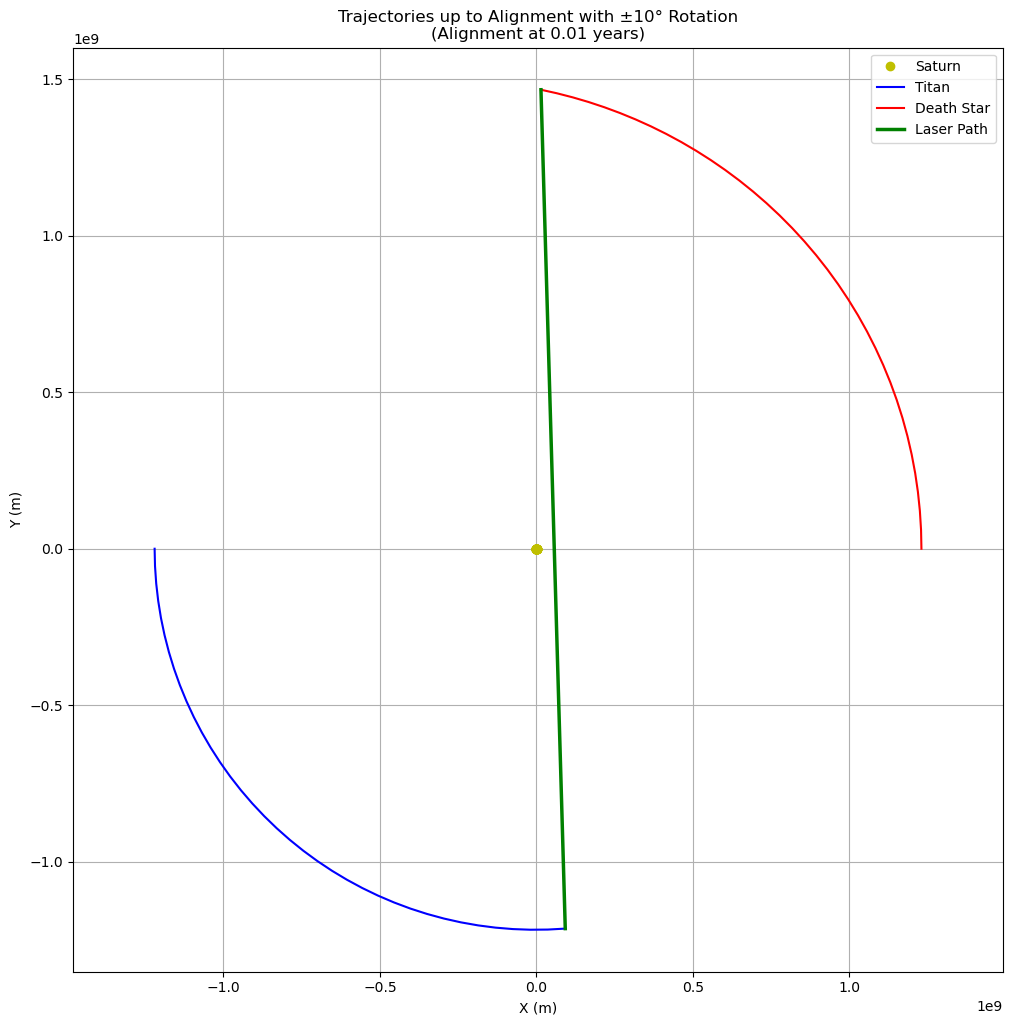

Alignment occurs after 0 years, 4 days, 6 hours, and 2800 seconds.


ValueError: operands could not be broadcast together with shapes (3,) (2,) 

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Constants and initial conditions
G = 6.67430e-11  # gravitational constant
M_s = 568.32e24  # mass of Saturn
M_t = 1.345e23   # mass of Titan
M_ds = 2.24e23   # mass of Death Star

r_s_radius = 58232e3  # Radius of Saturn
r_t_radius = 2575e3   # Radius of Titan
r_ds_radius = 60e3    # Radius of Death Star

r_s_initial = np.array([0.0, 0.0])  # Saturn at the origin
r_t_initial = np.array([-1.22e9, 0.0])  # Titan's distance from Saturn
r_ds_initial = np.array([1.22e9 + 1e7, 0.0])  # Death Star's distance from Saturn

v_s_initial = np.array([0.0, 0.0])  # Saturn is stationary
v_t_initial = np.array([0.0, -5.57e3])  # Titan's orbital speed
v_ds_initial = np.array([0.0, 5.57e3 + 500.0])  # Death Star's orbital speed

initial_state = np.hstack([r_s_initial, v_s_initial, r_t_initial, v_t_initial, r_ds_initial, v_ds_initial])

# Derivatives function
def derivatives(t, state):
    r_s, v_s, r_t, v_t, r_ds, v_ds = state.reshape(6, -1)
    d_st = np.linalg.norm(r_s - r_t)
    d_sds = np.linalg.norm(r_s - r_ds)
    d_tds = np.linalg.norm(r_t - r_ds)
    
    f_st = G * M_s * M_t / d_st**3
    f_sds = G * M_s * M_ds / d_sds**3
    f_tds = G * M_t * M_ds / d_tds**3
    
    a_s = f_st * (r_t - r_s) / M_s + f_sds * (r_ds - r_s) / M_s
    a_t = f_st * (r_s - r_t) / M_t + f_tds * (r_ds - r_t) / M_t
    a_ds = f_sds * (r_s - r_ds) / M_ds + f_tds * (r_t - r_ds) / M_ds
    
    return np.hstack([v_s, a_s, v_t, a_t, v_ds, a_ds])

def distance_from_line_to_point(line_point1, line_point2, point):
    numerator = np.abs((line_point2[1] - line_point1[1])*point[0] - 
                       (line_point2[0] - line_point1[0])*point[1] + 
                       line_point2[0]*line_point1[1] - 
                       line_point2[1]*line_point1[0])
    denominator = np.linalg.norm(line_point2 - line_point1)
    return numerator / denominator

def can_laser_hit_titan_with_rotation(r_s, r_t, r_ds, max_rotation_degree=10.0):
    for rotation in np.linspace(-np.radians(max_rotation_degree), np.radians(max_rotation_degree), 200):
        rotated_vector = np.array([
            np.cos(rotation) * (r_t - r_ds)[0] - np.sin(rotation) * (r_t - r_ds)[1],
            np.sin(rotation) * (r_t - r_ds)[0] + np.cos(rotation) * (r_t - r_ds)[1]
        ])
        
        laser_origin = r_ds - r_ds_radius * rotated_vector / np.linalg.norm(rotated_vector)
        laser_end = r_ds - (r_ds_radius + 10e7) * rotated_vector / np.linalg.norm(rotated_vector)  # Extend laser by 10 million km
        
        distance_to_titan = distance_from_line_to_point(laser_origin, laser_end, r_t)
        distance_to_saturn = distance_from_line_to_point(laser_origin, laser_end, r_s)
        
        if distance_to_titan <= r_t_radius and distance_to_saturn > r_s_radius:
            return True
    return False

# Integration using RK4
def rk4_step(func, y, t, dt):
    k1 = dt * func(t, y)
    k2 = dt * func(t + 0.5*dt, y + 0.5*k1)
    k3 = dt * func(t + 0.5*dt, y + 0.5*k2)
    k4 = dt * func(t + dt, y + k3)
    y_next = y + (k1 + 2*k2 + 2*k3 + k4) / 6.0
    return y_next

def integrate_rk4(func, y0, t_span, dt):
    t_values = [t_span[0]]
    y_values = [y0]
    t = t_span[0]
    y = y0
    while t < t_span[1]:
        y = rk4_step(func, y, t, dt)
        t += dt
        t_values.append(t)
        y_values.append(y)
    return np.array(t_values), np.array(y_values)

# Time step and span
dt = 1e4
t_span_20_years = (0, 20 * 365 * 24 * 3600)
t_values_20_years, y_values_20_years = integrate_rk4(derivatives, initial_state, t_span_20_years, dt)

# Check alignment with rotation
correct_alignment_time_with_rotation = None
for t, y in zip(t_values_20_years, y_values_20_years):
    r_s, r_t, r_ds = y[0:2], y[4:6], y[8:10]
    if can_laser_hit_titan_with_rotation(r_s, r_t, r_ds, 10.0):
        correct_alignment_time_with_rotation = t
        break

# Extract trajectories for visualization
index_of_alignment = np.where(t_values_20_years == correct_alignment_time_with_rotation)[0][0]
r_s_up_to_alignment = y_values_20_years[:index_of_alignment, 0:2]
r_t_up_to_alignment = y_values_20_years[:index_of_alignment, 4:6]
r_ds_up_to_alignment = y_values_20_years[:index_of_alignment, 8:10]

# Visualization
plt.figure(figsize=(12, 12))
plt.plot(r_s_up_to_alignment[:, 0], r_s_up_to_alignment[:, 1], 'yo', label='Saturn')
plt.plot(r_t_up_to_alignment[:, 0], r_t_up_to_alignment[:, 1], 'b-', label='Titan')
plt.plot(r_ds_up_to_alignment[:, 0], r_ds_up_to_alignment[:, 1], 'r-', label='Death Star')

laser_origin = r_ds_up_to_alignment[-1] - (r_t_up_to_alignment[-1] - r_ds_up_to_alignment[-1]) * r_ds_radius / np.linalg.norm(r_t_up_to_alignment[-1] - r_ds_up_to_alignment[-1])
plt.plot([laser_origin[0], r_t_up_to_alignment[-1][0]], [laser_origin[1], r_t_up_to_alignment[-1][1]], 'g-', label='Laser Path', linewidth=2.5)

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title(f'Trajectories up to Alignment with ±10° Rotation\n(Alignment at {correct_alignment_time_with_rotation/(365*24*3600):.2f} years)')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

# Convert the alignment time into years, days, hours, and seconds
def convert_seconds_to_time_units(seconds):
    years = seconds // (365 * 24 * 3600)
    seconds %= (365 * 24 * 3600)
    days = seconds // (24 * 3600)
    seconds %= (24 * 3600)
    hours = seconds // 3600
    seconds %= 3600
    return years, days, hours, seconds

alignment_time_years, alignment_time_days, alignment_time_hours, alignment_time_seconds = convert_seconds_to_time_units(correct_alignment_time_with_rotation)

print(f"Alignment occurs after {alignment_time_years:.0f} years, {alignment_time_days:.0f} days, {alignment_time_hours:.0f} hours, and {alignment_time_seconds:.0f} seconds.")





NameError: name 'find_correct_alignment_with_rotation' is not defined